# **An Explainable Ensemble Learning Framework for Fair and Accurate Loan Approval**
**Objective:** Predict loan approval using advanced features and explain model decisions using SHAP.

---

## ⚙️ Setup and GPU Check

In [1]:
import tensorflow as tf
print("✅ Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi

✅ Num GPUs Available: 1
Sun Jun 29 14:41:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------

## 📚 Install & Import Required Libraries

In [2]:
!pip install -q catboost shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import shap
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.0 MB/s eta 0:00:00


## 📥 Download and Load Dataset

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json here
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d taweilo/loan-approval-classification-data
!unzip -q loan-approval-classification-data.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data
License(s): apache-2.0
  0% 0.00/751k [00:00<?, ?B/s]
100% 751k/751k [00:00<00:00, 893MB/s]


In [4]:
df = pd.read_csv('loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## 📊 Exploratory Data Analysis (EDA)

In [5]:
# Overview
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


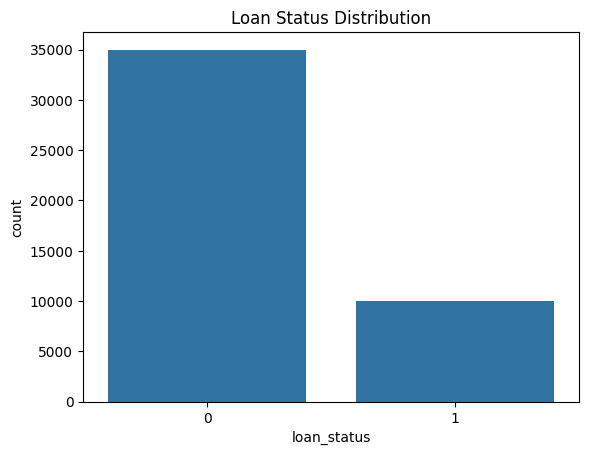

In [6]:
# Class Distribution
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.show()

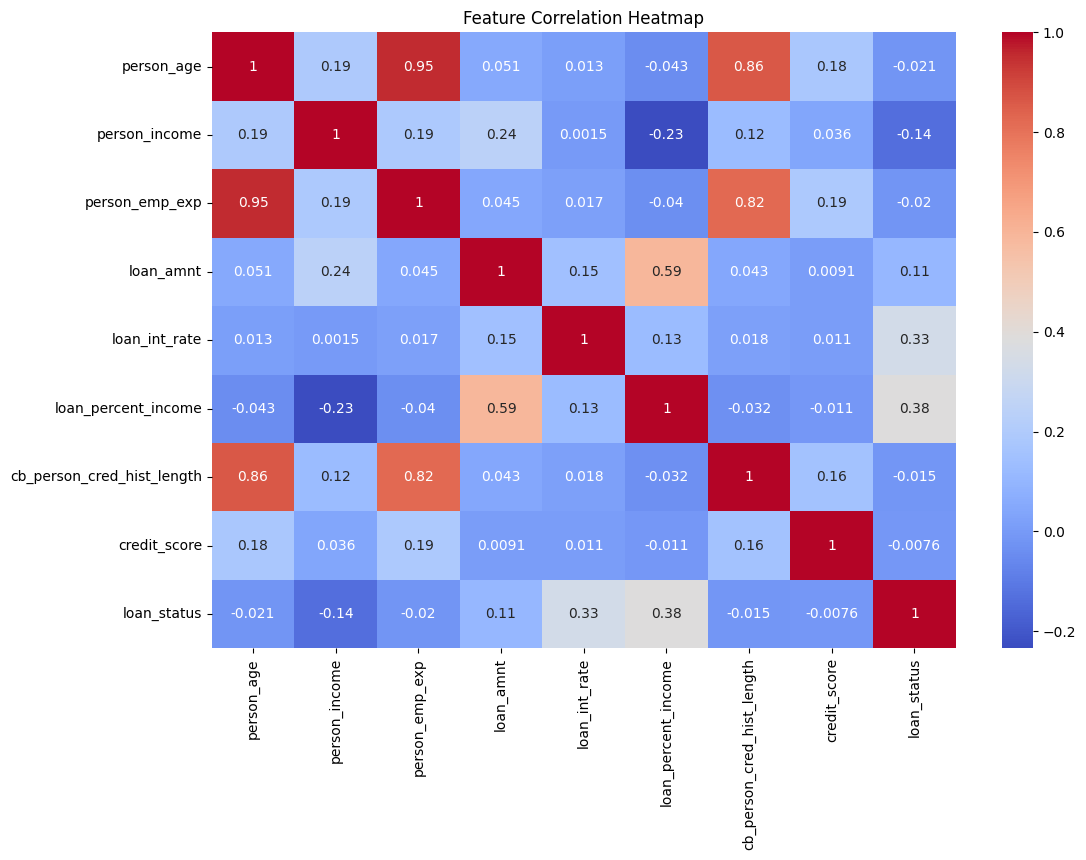

In [8]:
# Correlation Heatmap (numeric features only)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])  # Select only numerical columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


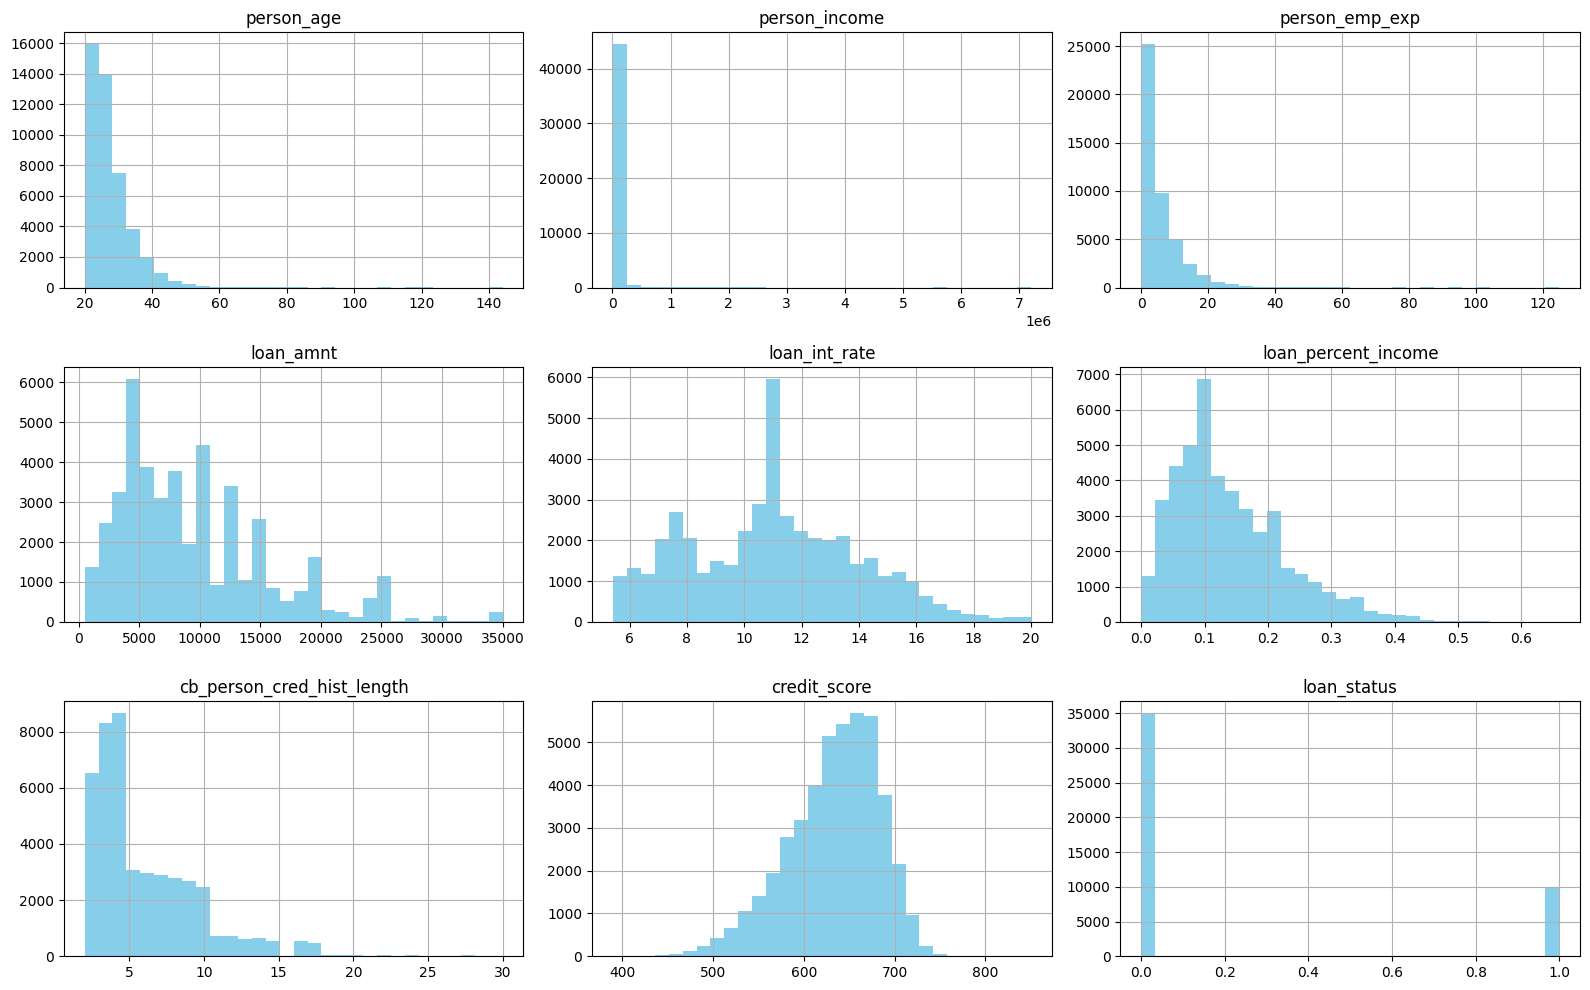

In [9]:
# Distribution of Numerical Features
df.hist(bins=30, figsize=(16, 10), color='skyblue')
plt.tight_layout()
plt.show()

## 🧹 Data Preprocessing

In [10]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

cat_features = X.select_dtypes(include='object').columns.tolist()
X[cat_features] = X[cat_features].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🤖 Train CatBoost Model

In [11]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    loss_function='Logloss',
    cat_features=cat_features,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9493133	best: 0.9493133 (0)	total: 65ms	remaining: 32.5s
100:	test: 0.9706750	best: 0.9706750 (100)	total: 1.81s	remaining: 7.15s
200:	test: 0.9722683	best: 0.9722683 (200)	total: 3.33s	remaining: 4.95s
300:	test: 0.9738548	best: 0.9738548 (300)	total: 4.81s	remaining: 3.18s
400:	test: 0.9748437	best: 0.9748437 (400)	total: 6.32s	remaining: 1.56s
499:	test: 0.9758053	best: 0.9758157 (495)	total: 7.79s	remaining: 0us

bestTest = 0.9758156998
bestIteration = 495

Shrink model to first 496 iterations.


## 📈 Evaluation Metrics

In [12]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6990
           1       0.89      0.78      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.88      0.89      9000
weighted avg       0.93      0.93      0.93      9000

ROC-AUC Score: 0.9758


## 🔍 SHAP Explainability

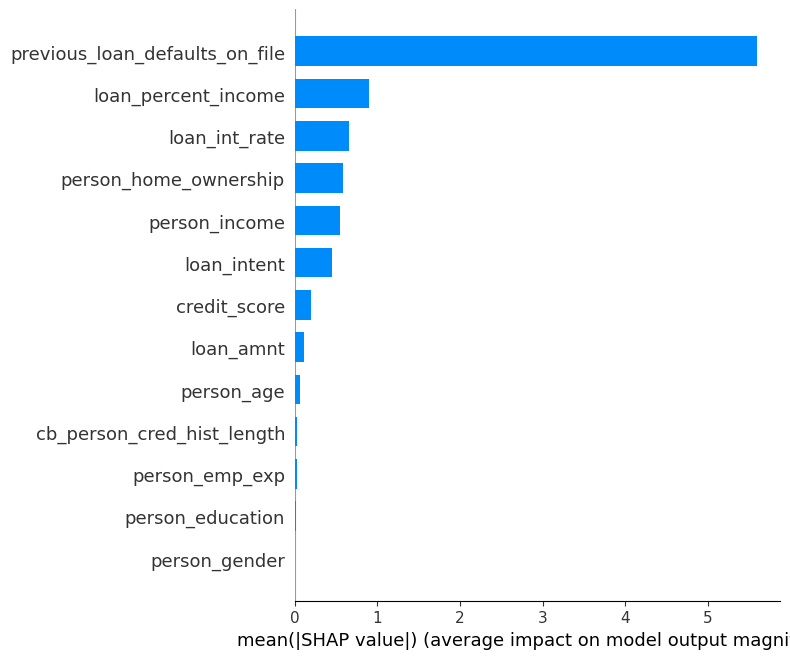

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

Thank You